### Import packages

In [1]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### Load the dataset

In [2]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization used in ResNet
])

dataset = datasets.ImageFolder(root="./dataset", transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_data = DataLoader(train_data, batch_size=32, shuffle=True)
val_data = DataLoader(val_data, batch_size=32, shuffle=False)
test_data = DataLoader(test_data, batch_size=32, shuffle=False)

In [3]:
image, label = dataset[0]
print(f"Label: {label}, Image shape: {image.shape}")

Label: 0, Image shape: torch.Size([3, 128, 128])


In [4]:
print(dataset.classes)

['kawung', 'mega_mendung', 'parang', 'truntum']


### Define the CNN model

In [5]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = self.pool(nn.ReLU()(self.conv4(x)))

        x = x.view(-1, 256 * 8 * 8)

        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### Functions

In [6]:
def evaluate(model, eval_data, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in eval_data:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    
    return accuracy

In [7]:
def train(model, train_data, val_data, criterion, optimizer, device, num_epoch=1000):
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)
    
    model.train()

    for epoch in range(num_epoch):
        epsilon = 0.001
        running_loss = 0.0
        
        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)
        
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()

        val_accuracy = evaluate(model, val_data, device)

        print(f"Epoch {epoch+1}/{num_epoch}, Loss: {running_loss/len(train_data):.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if running_loss/len(train_data) <= epsilon or val_accuracy >= 90:
            break

In [8]:
def test(model, test_data, device):
    data_iter = iter(test_data)
    images, labels = next(data_iter)
    random_id = random.randint(0, len(images) - 1)

    image = images[random_id].unsqueeze(0).to(device)
    label = labels[random_id].item()

    model.eval()

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    class_name = dataset.classes[predicted.item()]

    plt.imshow(image.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {class_name}, Actual: {dataset.classes[label]}")
    plt.axis("off")
    plt.show()

### Train, validate, and test the model

In [9]:
num_classes = len(dataset.classes)
model = CNNModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train(model, train_data, val_data, criterion, optimizer, device)

Epoch 1/1000, Loss: 1.4585, Validation Accuracy: 47.2222
Epoch 2/1000, Loss: 1.1633, Validation Accuracy: 56.3492
Epoch 3/1000, Loss: 1.1149, Validation Accuracy: 51.9841
Epoch 4/1000, Loss: 1.0526, Validation Accuracy: 55.1587
Epoch 5/1000, Loss: 1.0335, Validation Accuracy: 55.9524
Epoch 6/1000, Loss: 1.0327, Validation Accuracy: 50.7937
Epoch 7/1000, Loss: 0.9466, Validation Accuracy: 67.0635
Epoch 8/1000, Loss: 0.8513, Validation Accuracy: 65.0794
Epoch 9/1000, Loss: 0.8828, Validation Accuracy: 63.0952
Epoch 10/1000, Loss: 0.8562, Validation Accuracy: 67.4603
Epoch 11/1000, Loss: 0.7857, Validation Accuracy: 64.6825
Epoch 12/1000, Loss: 0.8109, Validation Accuracy: 67.8571
Epoch 13/1000, Loss: 0.8045, Validation Accuracy: 68.6508
Epoch 14/1000, Loss: 0.7209, Validation Accuracy: 69.4444
Epoch 15/1000, Loss: 0.7541, Validation Accuracy: 61.5079
Epoch 16/1000, Loss: 0.7229, Validation Accuracy: 69.4444
Epoch 17/1000, Loss: 0.7265, Validation Accuracy: 72.2222
Epoch 18/1000, Loss: 0.

In [27]:
accuracy = evaluate(model, val_data, device)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 91.2698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2317834].


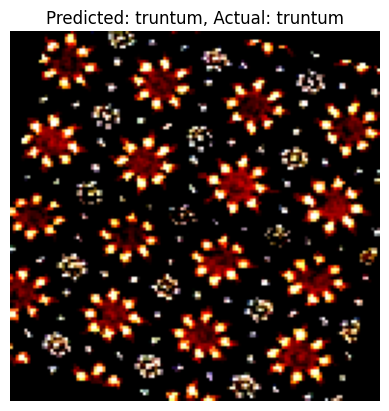

In [29]:
test(model, test_data, device)

In [30]:
torch.save(model.state_dict(), 'batik_classification_model.pth')